# Contexto del problema

Se quiere construir un modelo basado en redes neuronales artificiales que esté en capacidad de identificar el precio de viviendas basados en diferentes variables que explican dicho valor:

- price: precio de la vivienda. 
- lotSize: metros cuadrados de la vivienda. 
- age: antigüedad de la vivienda. 
- landValue: valor del terreno. 
- livingArea: metros cuadrados habitables. 
- pctCollege: porcentaje del vecindario con título universitario. 
- bedrooms: número de dormitorios. 
- firplaces: número de chimeneas. 
- bathrooms: número de cuartos de baño (el valor 0.5 hace referencia a cuartos de baño sin ducha). 
- rooms: número de habitaciones. 
- heating: tipo de calefacción. 
- fuel: tipo de alimentación de la calefacción (gas, electricidad o diesel). 
- sewer: tipo de desagüe. 
- waterfront: si la vivienda tiene vistas al lago. 
- newConstruction: si la vivienda es de nueva construcción. 
- centralAir: si la vivienda tiene aire acondicionado.

$y\rightarrow Precio ~ X [demás variables] $

# Librerías

In [2]:
#Tratamiento de datos
import numpy as np
import pandas as pd

#Gráficos
import matplotlib.pyplot as plt
import seaborn as sb

#Modelado de redes neuronales
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV

# Ajuste de datos
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Validación del modelo
from sklearn.metrics import r2_score, mean_absolute_percentage_error

# Advertencias
import warnings
warnings.filterwarnings("ignore")

Datos

In [3]:
url = "https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/master/data/SaratogaHouses.csv"
data = pd.read_csv(url)
data

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,waterfront,newConstruction,centralAir
0,132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No,No,No
1,181115,0.92,0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No,No,No
2,109000,0.19,133,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No,No,No
3,155000,0.41,13,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No,No,No
4,86060,0.11,0,15000,840,51,2,0,1.0,3,hot air,gas,public/commercial,No,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,289000,0.38,32,24200,2310,61,5,1,2.5,11,hot water/steam,gas,public/commercial,No,No,No
1724,285000,0.94,37,36200,2564,61,4,1,2.5,11,hot water/steam,gas,public/commercial,No,No,No
1725,194900,0.39,9,20400,1099,51,2,0,1.0,3,hot air,gas,public/commercial,No,No,No
1726,125000,0.24,48,16800,1225,51,3,1,1.0,7,hot air,gas,public/commercial,No,No,No


# Exploración de datos
Entender la calidad de los datos que tenemos disponibles

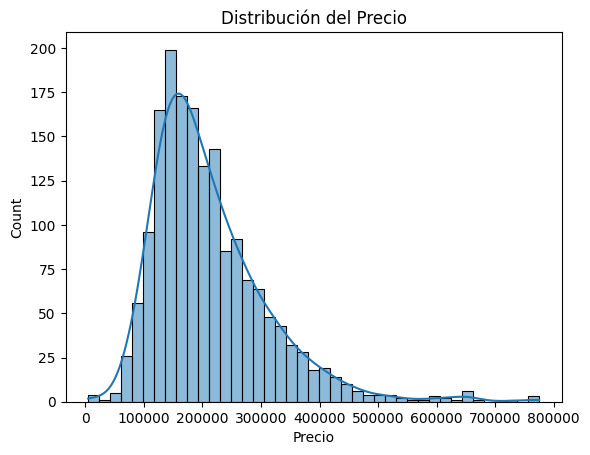

In [4]:
# Distribución de la variable respuesta
sb.histplot(data = data, x = 'price', kde = True)
plt.title('Distribución del Precio')
plt.xlabel('Precio')
plt.show()

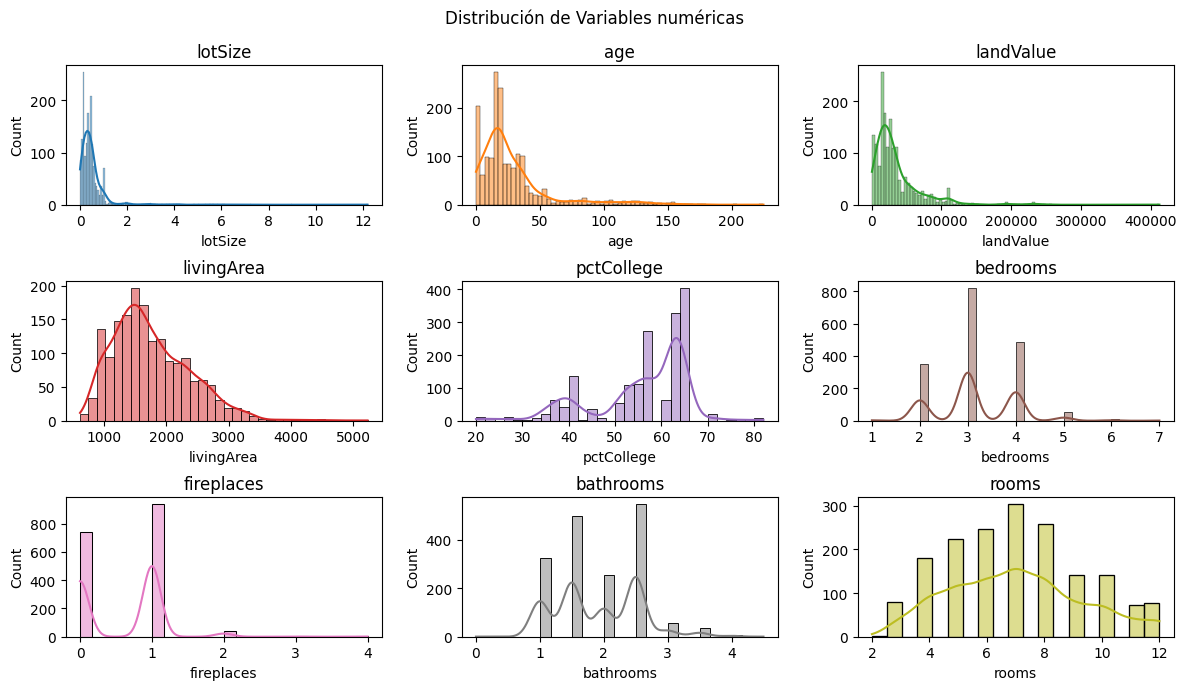

In [5]:
fig, axes = plt.subplots(3, 3, figsize = (12, 7))
axes = axes.flat
num_col = data.select_dtypes(include = ['int64', 'float64']).columns
num_col = num_col.drop('price')
for i, col in enumerate(num_col):
    sb.histplot(data = data,
                x = col,
                kde = True,
                color = (list(plt.rcParams['axes.prop_cycle']) * 2)[i]['color'], # *2 para tener + colores
                ax = axes[i])
    axes[i].set_title(col)
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
plt.suptitle('Distribución de Variables numéricas')
plt.show()

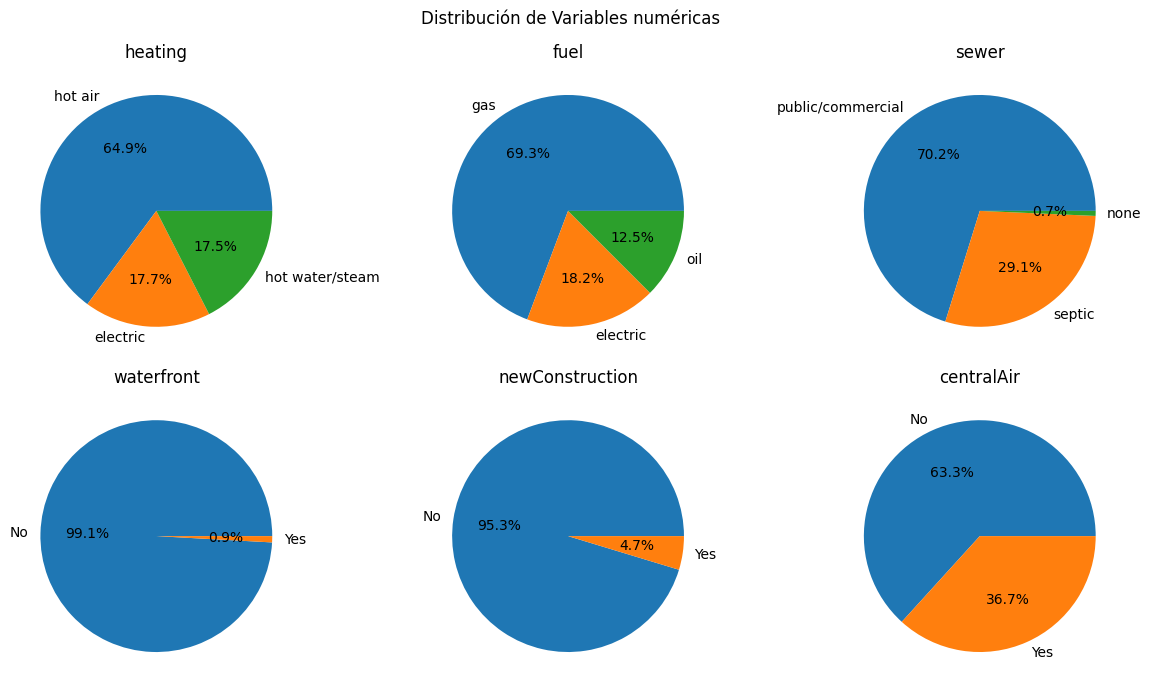

In [ ]:
fig, axes = plt.subplots(2, 3, figsize = (12, 7))
axes = axes.flat
cat_col = data.select_dtypes(include = ['object']).columns

for i, col in enumerate(cat_col):
    axes[i].pie(x = data[col].value_counts(),
                labels = data[col].value_counts().index,
                autopct = '%0.1f%%')
    axes[i].set_title(col)
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
plt.suptitle('Distribución de Variables categoricas')
plt.show()

In [7]:
data_mod = data.drop(['waterfront', 'newConstruction'], axis = 1)
data_mod

,price,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating,fuel,sewer,centralAir
0,132500,0.09,42,50000,906,35,2,1,1.0,5,electric,electric,septic,No
1,181115,0.92,0,22300,1953,51,3,0,2.5,6,hot water/steam,gas,septic,No
2,109000,0.19,133,7300,1944,51,4,1,1.0,8,hot water/steam,gas,public/commercial,No
3,155000,0.41,13,18700,1944,51,3,1,1.5,5,hot air,gas,septic,No
4,86060,0.11,0,15000,840,51,2,0,1.0,3,hot air,gas,public/commercial,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,289000,0.38,32,24200,2310,61,5,1,2.5,11,hot water/steam,gas,public/commercial,No
1724,285000,0.94,37,36200,2564,61,4,1,2.5,11,hot water/steam,gas,public/commercial,No
1725,194900,0.39,9,20400,1099,51,2,0,1.0,3,hot air,gas,public/commercial,No
1726,125000,0.24,48,16800,1225,51,3,1,1.0,7,hot air,gas,public/commercial,No


# Separación en entrenamiento y validación
- Separación 70 (entrenamiento) - 30 (validación)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data_mod.drop('price', axis = 1), data[['price']], train_size = 0.7, random_state = 123)

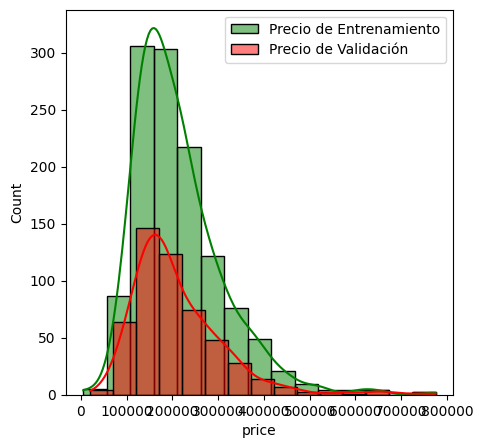

In [9]:
fig, ax = plt.subplots(figsize = (5,5))
sb.histplot(data = y_train, x = 'price', bins = 15, kde = True, color = 'green', label = 'Precio de Entrenamiento')
sb.histplot(data = y_test, x = 'price', bins = 15, kde = True, color = 'red', label = 'Precio de Validación')
plt.legend()
plt.show()

# Ajustar los datos
- Numéricas: escalar (llevar todas las var numéricas a un mismo rango estadístico)
- Categóricas: codificar (llevar todas las var categóricas a numéricas, si no las llevo no las puedo usar)

In [10]:
num_col = X_train.select_dtypes(include = ['int64', 'float64']).columns.to_list()
cat_col = X_train.select_dtypes(include = ['object']).columns.to_list()

num_transformer = Pipeline(steps = [('scaler', MinMaxScaler())])
cat_transformer = Pipeline(steps = [('encoder', OneHotEncoder())])

preprocessor = ColumnTransformer(transformers = [
    ('numeric', num_transformer, num_col),
    ('categorical', cat_transformer, cat_col)
], remainder = 'passthrough')

In [11]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['lotSize', 'age', 'landValue', 'livingArea',
                                  'pctCollege', 'bedrooms', 'fireplaces',
                                  'bathrooms', 'rooms']),
                                ('categorical',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 ['heating', 'fuel', 'sewer', 'centralAir'])])

In [12]:
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.fit_transform(X_test)

cod_cat = preprocessor.named_transformers_['categorical']['encoder'].get_feature_names_out(cat_col)
labels = np.concatenate([num_col, cod_cat])
X_train_pro = pd.DataFrame (X_train_pre, columns = labels)
X_train_pro

,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating_electric,heating_hot air,heating_hot water/steam,fuel_electric,fuel_gas,fuel_oil,sewer_none,sewer_public/commercial,sewer_septic,centralAir_No,centralAir_Yes
0,0.045119,0.000000,0.435148,0.329141,0.322581,0.500000,0.25,0.428571,0.7,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.041017,0.066667,0.157726,0.302472,0.709677,0.333333,0.25,0.428571,0.5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0.036916,0.000000,0.060048,0.505421,0.516129,0.500000,0.25,0.428571,0.8,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.000820,0.142222,0.089271,0.246531,0.241935,0.333333,0.00,0.142857,0.3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.018868,0.146667,0.195757,0.163053,0.596774,0.333333,0.00,0.000000,0.5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204,0.081214,0.048889,0.063251,0.074588,0.677419,0.333333,0.00,0.000000,0.3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1205,0.016407,0.075556,0.114492,0.122290,0.709677,0.166667,0.25,0.142857,0.2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1206,0.032814,0.253333,0.018415,0.316782,0.258065,0.333333,0.25,0.285714,0.5,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1207,0.036095,0.071111,0.099279,0.252385,0.322581,0.333333,0.25,0.142857,0.7,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [13]:
X_test_pro = pd.DataFrame(X_test_pre, columns = labels)
X_test_pro

,lotSize,age,landValue,livingArea,pctCollege,bedrooms,fireplaces,bathrooms,rooms,heating_electric,heating_hot air,heating_hot water/steam,fuel_electric,fuel_gas,fuel_oil,sewer_none,sewer_public/commercial,sewer_septic,centralAir_No,centralAir_Yes
0,0.065775,0.218935,0.009223,0.111111,0.258065,0.333333,0.000000,0.250,0.333333,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.040134,0.236686,0.007282,0.083333,0.258065,0.333333,0.000000,0.250,0.222222,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
2,0.046823,0.124260,0.028277,0.179398,0.709677,0.333333,0.000000,0.375,0.333333,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.022297,0.615385,0.253398,0.388310,0.596774,0.833333,0.000000,0.250,0.888889,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.012263,0.715976,0.209709,0.455729,0.677419,0.500000,0.000000,0.500,0.555556,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,0.004459,0.088757,0.085922,0.385417,0.596774,0.333333,0.333333,0.625,0.555556,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
515,0.010033,0.071006,0.074272,0.395833,0.516129,0.500000,0.333333,0.625,0.444444,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
516,0.111483,0.159763,0.018689,0.132234,0.290323,0.166667,0.000000,0.250,0.444444,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
517,0.054627,0.112426,0.150971,0.446181,0.709677,0.500000,0.333333,0.625,0.777778,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


# Modelación de los datos

Una red neuronal artificial, tipo Perceptron multicapa

- Busqueda de hiperparámetros:

Busqueda aleatorizada, en un rango de búsqueda definido encontrar un subconjunto de modelos para determinar el mejor.


Capas ocultas, neuronas por capa oculta, tasa de aprendizaje, funcion de activación y la cantidad de iteraciones.

In [25]:
modelo_base = MLPRegressor(random_state = 123)

param_grid = {
  'hidden_layer_sizes': [(10,), (20, 20), (40, 20), (20, 10), (20, 20, 20)],
  'learning_rate_init': [0.01, 0.1, 1, 10, 100],
  'activation': ['logistic', 'tanh', 'relu'],
  'max_iter': [50, 100, 200, 500],
}

estimador = RandomizedSearchCV(
  estimator = modelo_base,
  param_distributions = param_grid,
  cv = 3,
  n_iter = 50,
  random_state = 123,
)

estimador.fit(X_train_pro, y_train)

RandomizedSearchCV(cv=3, estimator=MLPRegressor(random_state=123), n_iter=50,
                   param_distributions={'activation': ['logistic', 'tanh',
                                                       'relu'],
                                        'hidden_layer_sizes': [(10,), (20, 20),
                                                               (40, 20),
                                                               (20, 10),
                                                               (20, 20, 20)],
                                        'learning_rate_init': [0.01, 0.1, 1, 10,
                                                               100],
                                        'max_iter': [50, 100, 200, 500]},
                   random_state=123)

In [26]:
validacion = pd.concat(
  [
    pd.DataFrame(estimador.cv_results_['params']),
    pd.DataFrame(estimador.cv_results_['mean_test_score'], columns = ['Score'])
  ],
  axis = 1
)

validacion.sort_values(by = 'Score', ascending = False)

,max_iter,learning_rate_init,hidden_layer_sizes,activation,Score
30,200,0.10,"(20, 10)",relu,0.613599
47,100,0.10,"(20, 20, 20)",relu,0.612248
7,500,10.00,"(20, 20)",relu,0.608524
49,200,10.00,"(20, 20)",relu,0.608524
45,50,0.10,"(20, 20, 20)",relu,0.592974
37,500,1.00,"(40, 20)",relu,0.583989
27,100,0.10,"(20, 10)",relu,0.583538
11,500,0.01,"(20, 20)",relu,0.581508
46,50,1.00,"(20, 20, 20)",relu,0.467272
0,200,0.01,"(20, 10)",relu,0.413206


# Validación

- Calcular el R2
- Calcular MAPE

Determinar que el modelo ante datos desconocidos opera de la misma manera

In [27]:
modelo = estimador.best_estimator_
modelo

MLPRegressor(hidden_layer_sizes=(20, 10), learning_rate_init=0.1,
             random_state=123)

In [29]:
y_pred = modelo.predict(X_test_pro)
y_pred

array([137704.62997889, 115557.63555659, 161249.11183143, 249474.61829091,
       266455.67877528, 167008.78518645, 152278.14723525, 165058.07582061,
       285600.14482996, 215156.13783693, 364365.12601388, 314694.48250566,
       111191.61628283, 248833.72399439, 222801.99792346, 356908.83472848,
       125923.13869869, 281363.89951946, 214108.89753522, 151007.76987454,
       205671.87164655, 142688.98575634, 300104.23821285, 179558.1467376 ,
       449999.44315677, 223021.42239343, 198593.12784946, 179235.36902942,
       166552.77611792, 362457.95016963, 146375.1638187 , 407326.20732673,
       363994.9125651 , 266080.21931871, 171232.31847458, 203154.43873966,
       584642.9286888 , 325205.6363525 , 106464.59451861, 227867.70255589,
       330051.36099974, 244058.43442549, 292655.32258325, 181650.60631537,
       155032.4888733 , 278424.79507964, 269219.13753122, 220189.3061363 ,
       127994.95983136, 281753.07505077, 126088.1471691 , 188785.57385758,
       182289.69430596, 3

## Calcular R2

In [31]:
r2 = r2_score(y_test, y_pred)
print(f'El ajuste de validación es: {r2:.2f}')

El ajuste de validación es: 0.51


## Calcular el MAPE

In [32]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'El MAPE de validación es: {mape:.2f}')

El MAPE de validación es: 0.28


# Metricas

In [33]:
((0.61 - 0.51) / 0.61) * 100

16.393442622950815

En modelos de clasificación la metrica de desempeño supera en un 10% la variación, hablamos de un modelo mal ajustado.

En modelos de regresion la metrica de desempeño supera en un 20% la variación, hablamos de un modelo mal ajustado.